## Problem Statement 

You need to build a model that is able to classify customer complaints based on the products/services. By doing so, you can segregate these tickets into their relevant categories and, therefore, help in the quick resolution of the issue.

You will be doing topic modelling on the <b>.json</b> data provided by the company. Since this data is not labelled, you need to apply NMF to analyse patterns and classify tickets into the following five clusters based on their products/services:

* Credit card / Prepaid card

* Bank account services

* Theft/Dispute reporting

* Mortgages/loans

* Others 


With the help of topic modelling, you will be able to map each ticket onto its respective department/category. You can then use this data to train any supervised model such as logistic regression, decision tree or random forest. Using this trained model, you can classify any new customer complaint support ticket into its relevant department.

## Pipelines that needs to be performed:

You need to perform the following eight major tasks to complete the assignment:

1.  Data loading

2. Text preprocessing

3. Exploratory data analysis (EDA)

4. Feature extraction

5. Topic modelling 

6. Model building using supervised learning

7. Model training and evaluation

8. Model inference

## Importing the necessary libraries

In [1]:
import json 
import numpy as np
import pandas as pd
import re, nltk, spacy, string
import en_core_web_sm
nlp = en_core_web_sm.load()
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

from plotly.offline import plot
import plotly.graph_objects as go
import plotly.express as px

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer, TfidfTransformer
from pprint import pprint

from nltk.corpus import stopwords

from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.metrics import confusion_matrix, f1_score, classification_report

from sklearn.linear_model import LogisticRegression

import pickle
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [2]:
import swifter # to speed up pandas apply function

## Loading the data

The data is in JSON format and we need to convert it to a dataframe.

In [3]:
# Opening JSON file 
with open("complaints.json","r") as f: 
    # returns JSON object as  
    # a dictionary 
    data = json.load(f)
    df=pd.json_normalize(data)

## Data preparation

In [4]:
# Inspect the dataframe to understand the given data.
print(df.shape)
df.head()

(78313, 22)


,_index,_type,_id,_score,_source.tags,_source.zip_code,_source.complaint_id,_source.issue,_source.date_received,_source.state,...,_source.company_response,_source.company,_source.submitted_via,_source.date_sent_to_company,_source.company_public_response,_source.sub_product,_source.timely,_source.complaint_what_happened,_source.sub_issue,_source.consumer_consent_provided
0,complaint-public-v2,complaint,3211475,0.0,None,90301,3211475,Attempts to collect debt not owed,2019-04-13T12:00:00-05:00,CA,...,Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-04-13T12:00:00-05:00,None,Credit card debt,Yes,,Debt is not yours,Consent not provided
1,complaint-public-v2,complaint,3229299,0.0,Servicemember,319XX,3229299,Written notification about debt,2019-05-01T12:00:00-05:00,GA,...,Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-05-01T12:00:00-05:00,None,Credit card debt,Yes,Good morning my name is XXXX XXXX and I apprec...,Didn't receive enough information to verify debt,Consent provided
2,complaint-public-v2,complaint,3199379,0.0,None,77069,3199379,"Other features, terms, or problems",2019-04-02T12:00:00-05:00,TX,...,Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-04-02T12:00:00-05:00,None,General-purpose credit card or charge card,Yes,I upgraded my XXXX XXXX card in XX/XX/2018 and...,Problem with rewards from credit card,Consent provided
3,complaint-public-v2,complaint,2673060,0.0,None,48066,2673060,Trouble during payment process,2017-09-13T12:00:00-05:00,MI,...,Closed with explanation,JPMORGAN CHASE & CO.,Web,2017-09-14T12:00:00-05:00,None,Conventional home mortgage,Yes,,None,Consent not provided
4,complaint-public-v2,complaint,3203545,0.0,None,10473,3203545,Fees or interest,2019-04-05T12:00:00-05:00,NY,...,Closed with explanation,JPMORGAN CHASE & CO.,Referral,2019-04-05T12:00:00-05:00,None,General-purpose credit card or charge card,Yes,,Charged too much interest,N/A


In [5]:
#print the column names
df.columns

Index(['_index', '_type', '_id', '_score', '_source.tags', '_source.zip_code',
       '_source.complaint_id', '_source.issue', '_source.date_received',
       '_source.state', '_source.consumer_disputed', '_source.product',
       '_source.company_response', '_source.company', '_source.submitted_via',
       '_source.date_sent_to_company', '_source.company_public_response',
       '_source.sub_product', '_source.timely',
       '_source.complaint_what_happened', '_source.sub_issue',
       '_source.consumer_consent_provided'],
      dtype='object')

In [6]:
#Assign new column names
df.rename(columns = {'_source.complaint_what_happened':'complaints','_index':'index', '_type':'type', '_id':'id', '_score':'score', '_source.tags':'tags', '_source.zip_code':'zip_code',
       '_source.complaint_id':'complaint_id', '_source.issue':'issue', '_source.date_received':'date_received',
       '_source.state':'state', '_source.consumer_disputed':'.consumer_disputed', '_source.product':'product',
       '_source.company_response':'company_response', '_source.company':'company', '_source.submitted_via':'submitted_via',
       '_source.date_sent_to_company':'date_sent_to_company', '_source.company_public_response':'company_public_response',
       '_source.sub_product':'sub_product', '_source.timely':'timely',
        '_source.sub_issue':'sub_issue',
       '_source.consumer_consent_provided':'consumer_consent_provided'}, inplace = True)

In [7]:
# check new column names
df.columns

Index(['index', 'type', 'id', 'score', 'tags', 'zip_code', 'complaint_id',
       'issue', 'date_received', 'state', '.consumer_disputed', 'product',
       'company_response', 'company', 'submitted_via', 'date_sent_to_company',
       'company_public_response', 'sub_product', 'timely', 'complaints',
       'sub_issue', 'consumer_consent_provided'],
      dtype='object')

In [8]:
#Assign nan in place of blanks in the complaints column
df[df["complaints"]==""] == np.nan

In [9]:
#Remove all rows where complaints column is nan
df = df[df.complaints.notnull()]

## Prepare the text for topic modeling

Once you have removed all the blank complaints, you need to:

* Make the text lowercase
* Remove text in square brackets
* Remove punctuation
* Remove words containing numbers


Once you have done these cleaning operations you need to perform the following:
* Lemmatize the texts
* Extract the POS tags of the lemmatized text and remove all the words which have tags other than NN[tag == "NN"].


In [10]:
def clean_texts(text):
    text=text.lower()
    #Remove text in square brackets
    text=re.sub(r'\[.*?\]', '',text)
    #Remove words containing numbers
    text = re.sub(r'\w*\d\w*', '', text)
    # Removing punctuations in string
    # Using regex
    text = re.sub(r'[^\w\s]', '', text)

    return text

In [11]:
df[df["id"]=="3370885"].complaints

142    ChaseMortgagehasautomaticallydeducted2mortgage...
Name: complaints, dtype: object

I see that there's no space between words, let's delete those sentences having word len greater than 40chars

In [12]:
comps = [sent for sent in df["complaints"] for words in sent if len(words)<40]

In [13]:
df = df[df.complaints.isin(comps) == True]

In [14]:
df["complaints"] = df["complaints"].swifter.apply(lambda x: clean_texts(x))

Pandas Apply:   0%|          | 0/21072 [00:00<?, ?it/s]

## The personal details of customer has been masked in the dataset with xxxx. Let's remove the masked text as this will be of no use for our analysis

In [15]:
df["complaints"] = df["complaints"].swifter.apply(lambda x: re.sub(r'xx+', '', x))

Pandas Apply:   0%|          | 0/21072 [00:00<?, ?it/s]

In [16]:
# Lemmatize the texts

def lemmatization(texts):
    texts_out = []
    for doc in nlp.pipe(texts, batch_size=32, n_process=3, disable=["parser", "ner"]):
        texts_out.append(" ".join([token.lemma_ for token in doc]))
    return texts_out


In [17]:
# lemmatization keeping only noun, adj, vb, adv
data_lemmatized = lemmatization(df["complaints"])

In [18]:
print(data_lemmatized[0])

good morning my name be    and I appreciate it if you could help I put a stop to chase bank cardmember service 
 in   I write to chase ask for debt verification and what they send I a statement which be not acceptable I be ask the bank to validate the debt instead I be receive mail every month from they attempt to collect a debt 
 I have a right to know this information as a consumer 

 chase account       thank in advance for your help


In [19]:
#Create a dataframe('df_clean') that will have only the complaints and the lemmatized complaints 
df_clean = pd.DataFrame({"complaints":df["complaints"],"lemmatized":data_lemmatized})

In [20]:
df_clean

,complaints,lemmatized
1,good morning my name is and i appreciate it ...,good morning my name be and I appreciate it...
2,i upgraded my card in and was told by the a...,I upgrade my card in and be tell by the a...
10,chase card was reported on however fraudulent...,chase card be report on however fraudulent a...
11,on while trying to book a ticket i came a...,on while try to book a ticket I come ac...
14,my grand son give me check for i deposit it i...,my grand son give I check for I deposit it i...
...,...,...
78303,after being a chase card customer for well ove...,after be a chase card customer for well over a...
78309,on wednesday i called chas my visa credit c...,on wednesday I call cha my visa credit ca...
78310,i am not familiar with pay and did not unders...,I be not familiar with pay and do not unders...
78311,i have had flawless credit for yrs ive had ch...,I have have flawless credit for yrs I ve hav...


In [21]:
df_clean.to_csv("df_clean24apr.csv",index=False)

In [22]:
#Write your function to extract the POS tags 

def pos_tag(texts):
    texts_out = []
    for doc in nlp.pipe(texts, batch_size=32, n_process=3, disable=["parser", "ner"]):
        texts_out.append(" ".join([token.text for token in doc if token.tag_ == "NN"]))
    return texts_out


In [23]:
complaint_POS_removed = pos_tag(data_lemmatized)

In [24]:
df_clean["complaint_POS_removed"] = complaint_POS_removed

In [25]:
#The clean dataframe should now contain the raw complaint, lemmatized complaint and the complaint after removing POS tags.
df_clean

,complaints,lemmatized,complaint_POS_removed
1,good morning my name is and i appreciate it ...,good morning my name be and I appreciate it...,morning name stop bank service debt verificati...
2,i upgraded my card in and was told by the a...,I upgrade my card in and be tell by the a...,card agent anniversary date agent information ...
10,chase card was reported on however fraudulent...,chase card be report on however fraudulent a...,card report application identity consent servi...
11,on while trying to book a ticket i came a...,on while try to book a ticket I come ac...,ticket offer ticket reward card information of...
14,my grand son give me check for i deposit it i...,my grand son give I check for I deposit it i...,son chase account fund chase bank account mone...
...,...,...,...
78303,after being a chase card customer for well ove...,after be a chase card customer for well over a...,chase card customer decade solicitation credit...
78309,on wednesday i called chas my visa credit c...,on wednesday I call cha my visa credit ca...,cha visa credit card provider claim purchase p...
78310,i am not familiar with pay and did not unders...,I be not familiar with pay and do not unders...,risk consumer chase bank app chase year bankin...
78311,i have had flawless credit for yrs ive had ch...,I have have flawless credit for yrs I ve hav...,credit chase credit card freedom problem balan...


In [26]:
df_clean.complaint_POS_removed.isna().sum()

0

In [27]:
df_clean.dropna(inplace=True)

## Exploratory data analysis to get familiar with the data.

Write the code in this task to perform the following:

*   Visualise the data according to the 'Complaint' character length
*   Using a word cloud find the top 40 words by frequency among all the articles after processing the text
*   Find the top unigrams,bigrams and trigrams by frequency among all the complaints after processing the text. ‘




In [28]:
# Write your code here to visualise the data according to the 'Complaint' character length
complaints_len = [ len(i) for i in df_clean.complaints ]

Text(-2.450000000000003, 0.5, 'Frequency')

<Figure size 720x432 with 0 Axes>

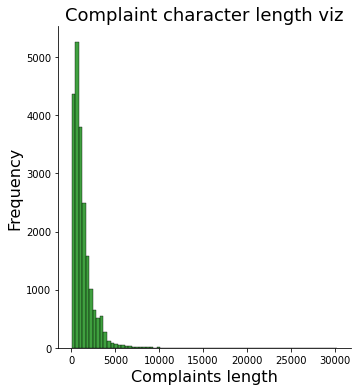

In [29]:
plt.figure(figsize=[10,6])
sns.displot(complaints_len, kde=False, color='green', bins=75)
plt.title('Complaint character length viz', fontsize=18)
plt.xlabel('Complaints length', fontsize=16)
plt.ylabel('Frequency', fontsize=16)

Text(3.674999999999997, 0.5, 'Frequency')

<Figure size 720x432 with 0 Axes>

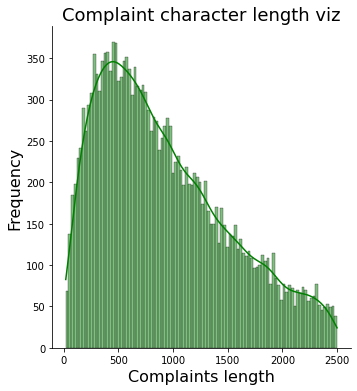

In [30]:
# lets visualize for complaint len less than 1500
complaints_len1 = [ len(i) for i in df_clean.complaints if len(i) <2500]
plt.figure(figsize=[10,6])
sns.displot(complaints_len1, color='green', bins=100,kde=True)
plt.title('Complaint character length viz', fontsize=18)
plt.xlabel('Complaints length', fontsize=16)
plt.ylabel('Frequency', fontsize=16)

We see that frequency of complaints having characters greater than 500 is decreasing

#### Find the top 40 words by frequency among all the articles after processing the text.

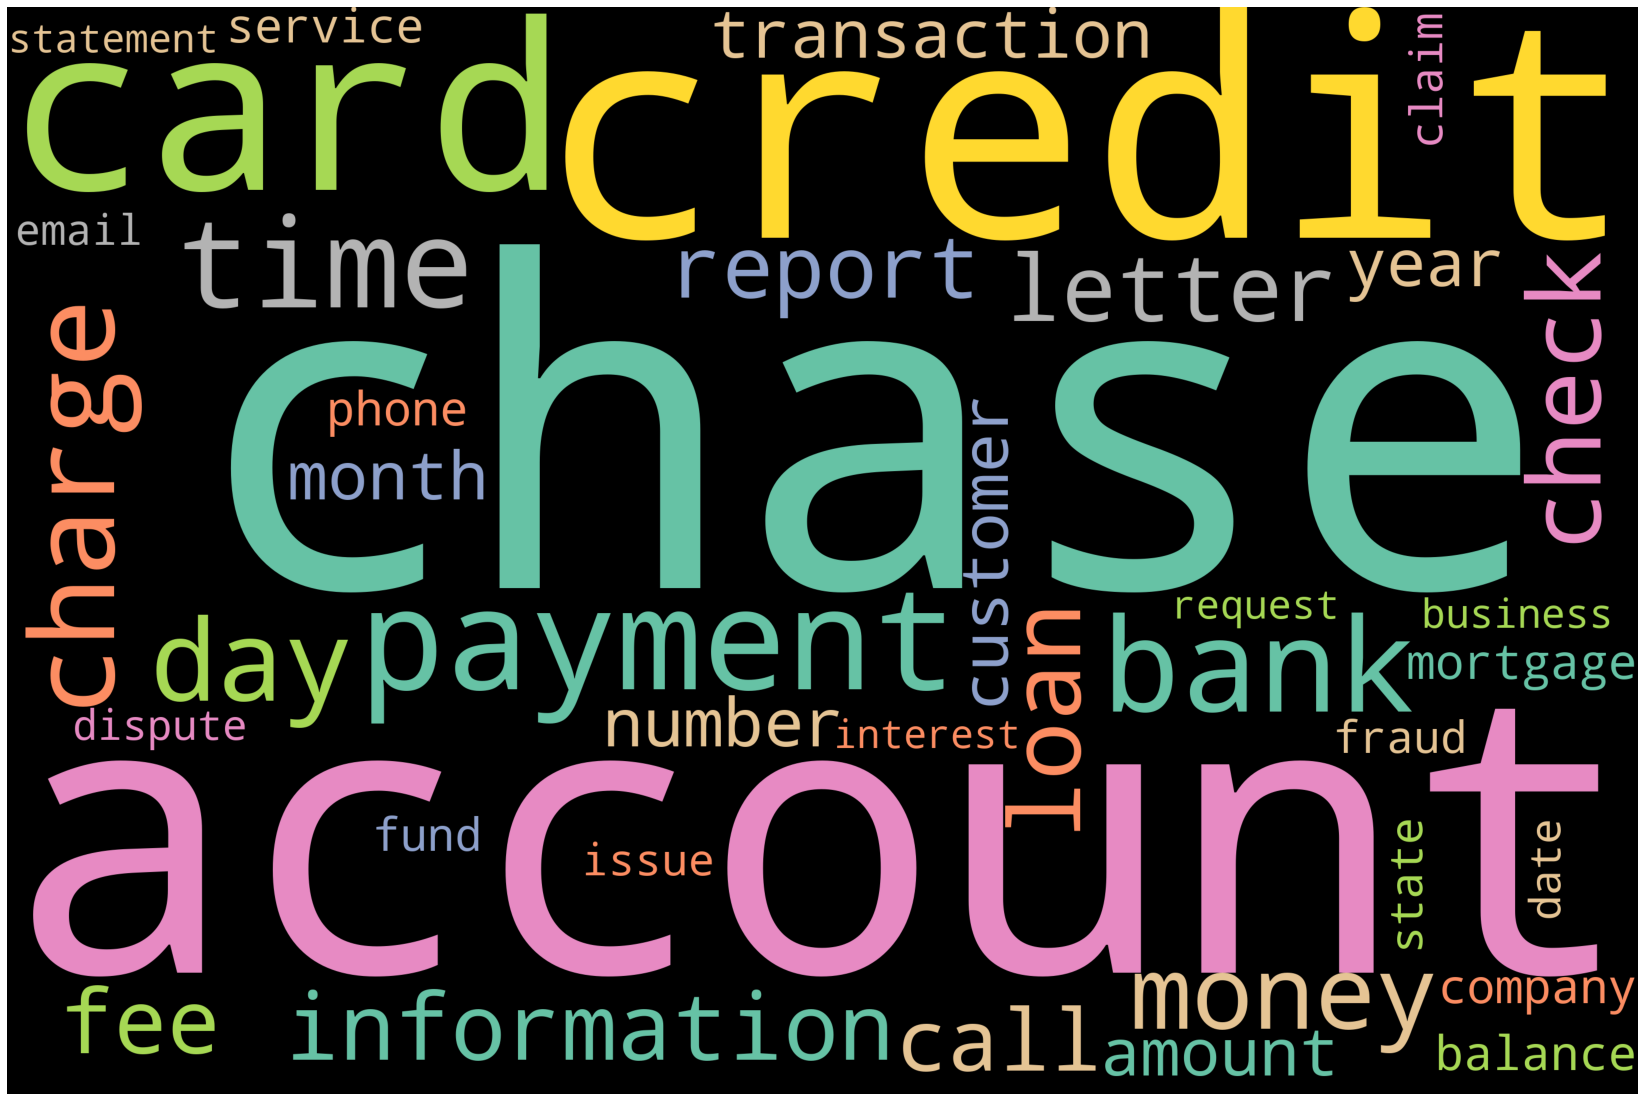

In [31]:
#Using a word cloud find the top 40 words by frequency among all the articles after processing the text

from wordcloud import WordCloud, STOPWORDS
stop_words = set(STOPWORDS)
comps = df_clean.complaint_POS_removed
doc = " ".join(comp for comp in comps)
wordcloud = WordCloud(width = 3000, height = 2000, random_state=1, max_words=40,stopwords=stop_words,
                      background_color='black', colormap='Set2', collocations=False).generate(doc)

plt.figure(figsize=(30, 20))
# Display image
plt.imshow(wordcloud) 
# No axis details
plt.axis("off");

In [32]:
#Removing -PRON- from the text corpus
df_clean['Complaint_clean'] = df_clean['complaint_POS_removed'].str.replace('-PRON-', '')

#### Find the top unigrams,bigrams and trigrams by frequency among all the complaints after processing the text.

In [33]:
# Function to return ngram word freq taking ngram_range as input
def get_ngrams(ngram_range):
    vector = CountVectorizer(ngram_range=ngram_range, stop_words='english').fit(df_clean['Complaint_clean'])
    bag_of_words = vector.transform(df_clean['Complaint_clean'])
    sum_of_words = bag_of_words.sum(axis=0) 
    word_freq = [(word, sum_of_words[0, idx]) for word, idx in vector.vocabulary_.items()]
    word_freq =sorted(word_freq, key = lambda x: x[1], reverse=True)
    return word_freq

In [34]:
#Write your code here to find the top 30 unigram frequency among the complaints in the cleaned datafram(df_clean). 
unigrams = get_ngrams((1,1))

In [35]:
#Print the top 10 words in the unigram frequency
unigrams[:10]

[('chase', 48482),
 ('account', 47415),
 ('credit', 33482),
 ('card', 29990),
 ('payment', 21134),
 ('bank', 17585),
 ('time', 16044),
 ('charge', 13989),
 ('day', 13174),
 ('money', 11907)]

In [36]:
# store top 30 unigrams to df for easy plot
df_unigram = pd.DataFrame(unigrams[:30], columns = ['unigram' , 'count'])

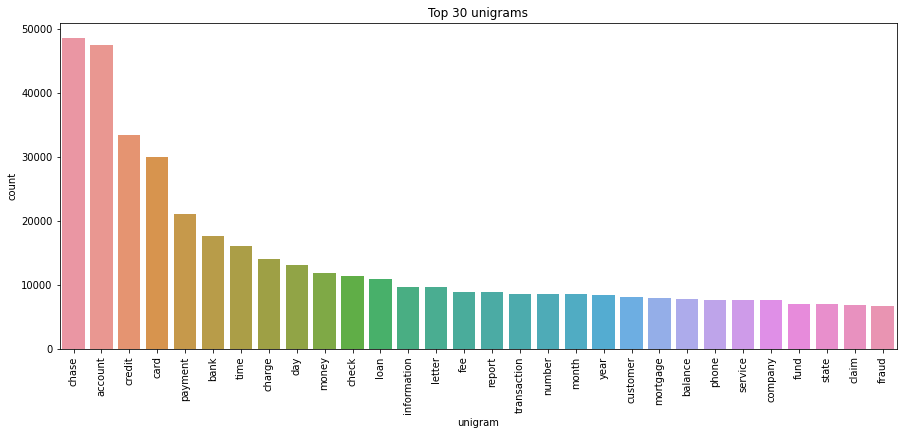

In [37]:
# Plot the top 30 unigrams
plt.figure(figsize=(15,6))
sns.barplot(x='unigram', y='count', data=df_unigram)
plt.xticks(rotation=90)
plt.title("Top 30 unigrams")
plt.show()

In [38]:
#Write your code here to find the top 30 bigram frequency among the complaints in the cleaned datafram(df_clean). 
bigrams = get_ngrams((2,2))

In [39]:
#Print the top 10 words in the bigram frequency
bigrams[:10]

[('credit card', 12857),
 ('credit report', 3977),
 ('customer service', 3084),
 ('chase credit', 3024),
 ('account chase', 2881),
 ('account account', 2686),
 ('chase account', 2580),
 ('checking account', 2558),
 ('bank account', 2228),
 ('debit card', 2029)]

In [40]:
df_bigram = pd.DataFrame(bigrams[:30], columns = ['bigram' , 'count'])

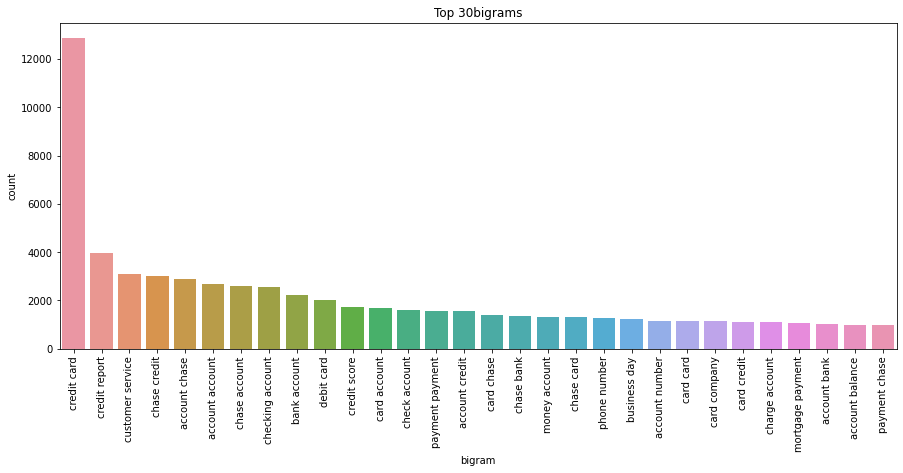

In [41]:
# Plot the top 30 unigrams
plt.figure(figsize=(15,6))
sns.barplot(x='bigram', y='count', data=df_bigram)
plt.xticks(rotation=90)
plt.title("Top 30bigrams")
plt.show()

In [42]:
#Write your code here to find the top 30 trigram frequency among the complaints in the cleaned datafram(df_clean). 
trigrams = get_ngrams((3,3))

In [43]:
#Print the top 10 words in the trigram frequency
trigrams[:10]

[('chase credit card', 2120),
 ('credit card account', 1107),
 ('credit card company', 995),
 ('credit card chase', 641),
 ('credit card credit', 566),
 ('inquiry credit report', 505),
 ('account credit card', 452),
 ('card credit card', 435),
 ('charge credit card', 404),
 ('credit report credit', 369)]

In [44]:
df_trigram = pd.DataFrame(trigrams[:30], columns = ['trigram' , 'count'])

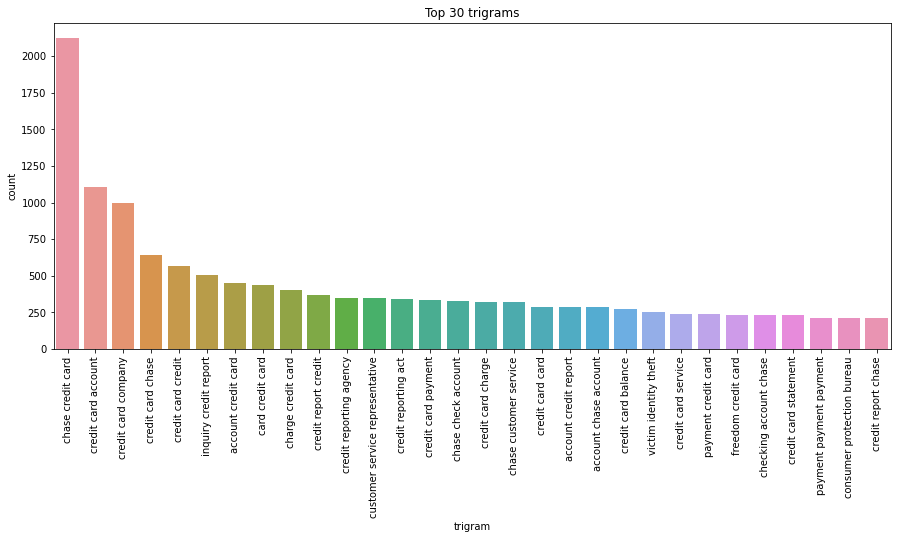

In [45]:
# Plot the top 30 unigrams
plt.figure(figsize=(15,6))
sns.barplot(x='trigram', y='count', data=df_trigram)
plt.xticks(rotation=90)
plt.title("Top 30 trigrams")
plt.show()

## Feature Extraction
Convert the raw texts to a matrix of TF-IDF features

**max_df** is used for removing terms that appear too frequently, also known as "corpus-specific stop words"
max_df = 0.95 means "ignore terms that appear in more than 95% of the complaints"

**min_df** is used for removing terms that appear too infrequently
min_df = 2 means "ignore terms that appear in less than 2 complaints"

In [46]:
#Write your code here to initialise the TfidfVectorizer 
tfidf = TfidfVectorizer(max_df=0.95, min_df=2, stop_words='english')

#### Create a document term matrix using fit_transform

The contents of a document term matrix are tuples of (complaint_id,token_id) tf-idf score:
The tuples that are not there have a tf-idf score of 0

In [47]:
#Write your code here to create the Document Term Matrix by transforming the complaints column present in df_clean.
dtm = tfidf.fit_transform(df_clean['complaint_POS_removed'])

In [48]:
pd.DataFrame(dtm.toarray(), columns=tfidf.get_feature_names())

,aa,aarp,abandonment,abatement,abbreviation,abet,abide,ability,abovementione,abovereference,...,yoga,youinv,youth,yr,yrs,zip,zipcode,zombie,zone,zoom
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21067,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
21068,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
21069,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
21070,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


## Topic Modelling using NMF

Non-Negative Matrix Factorization (NMF) is an unsupervised technique so there are no labeling of topics that the model will be trained on. The way it works is that, NMF decomposes (or factorizes) high-dimensional vectors into a lower-dimensional representation. These lower-dimensional vectors are non-negative which also means their coefficients are non-negative.

In this task you have to perform the following:

* Find the best number of clusters 
* Apply the best number to create word clusters
* Inspect & validate the correction of each cluster wrt the complaints 
* Correct the labels if needed 
* Map the clusters to topics/cluster names

In [49]:
from sklearn.decomposition import NMF

## Manual Topic Modeling
You need to do take the trial & error approach to find the best num of topics for your NMF model.

The only parameter that is required is the number of components i.e. the number of topics we want. This is the most crucial step in the whole topic modeling process and will greatly affect how good your final topics are.

In [50]:
#Load your nmf_model with the n_components i.e 5
num_topics = 5 #write the value you want to test out

#keep the random_state =40
nmf_model =  NMF(n_components=num_topics,random_state=40)
W = nmf_model.fit(dtm)  # Document-topic matrix
H = nmf_model.components_       # Topic-term matrix#write your code here

In [51]:
for index, topic in enumerate(nmf_model.components_):
    print(f'TOP 15 WORDS FOR TOPIC #{index}')
    print([tfidf.get_feature_names()[i] for i in topic.argsort()[-15:]])
    print('\n')

TOP 15 WORDS FOR TOPIC #0
['customer', 'transaction', 'transfer', 'business', 'number', 'checking', 'day', 'branch', 'deposit', 'chase', 'fund', 'money', 'bank', 'check', 'account']


TOP 15 WORDS FOR TOPIC #1
['reason', 'time', 'application', 'purchase', 'offer', 'month', 'point', 'year', 'score', 'limit', 'account', 'balance', 'chase', 'credit', 'card']


TOP 15 WORDS FOR TOPIC #2
['day', 'date', 'statement', 'property', 'balance', 'rate', 'year', 'time', 'modification', 'month', 'home', 'chase', 'mortgage', 'loan', 'payment']


TOP 15 WORDS FOR TOPIC #3
['date', 'letter', 'remove', 'theft', 'score', 'account', 'identity', 'bureaus', 'debt', 'reporting', 'company', 'information', 'credit', 'inquiry', 'report']


TOP 15 WORDS FOR TOPIC #4
['day', 'company', 'time', 'refund', 'email', 'service', 'purchase', 'fraud', 'claim', 'merchant', 'fee', 'chase', 'transaction', 'dispute', 'charge']




In [52]:
#Create the best topic for each complaint in terms of integer value 0,1,2,3 & 4
topic_result = nmf_model.transform(dtm)
topic_result[0].round(2)
topic_result[0].argmax()
topic_result.argmax(axis=1)

array([2, 1, 3, ..., 4, 1, 2])

In [53]:
#Assign the best topic to each of the cmplaints in Topic Column

df_clean['Topic'] = topic_result.argmax(axis=1) #write your code to assign topics to each rows.

In [54]:
df_clean.head()

,complaints,lemmatized,complaint_POS_removed,Complaint_clean,Topic
1,good morning my name is and i appreciate it ...,good morning my name be and I appreciate it...,morning name stop bank service debt verificati...,morning name stop bank service debt verificati...,2
2,i upgraded my card in and was told by the a...,I upgrade my card in and be tell by the a...,card agent anniversary date agent information ...,card agent anniversary date agent information ...,1
10,chase card was reported on however fraudulent...,chase card be report on however fraudulent a...,card report application identity consent servi...,card report application identity consent servi...,3
11,on while trying to book a ticket i came a...,on while try to book a ticket I come ac...,ticket offer ticket reward card information of...,ticket offer ticket reward card information of...,3
14,my grand son give me check for i deposit it i...,my grand son give I check for I deposit it i...,son chase account fund chase bank account mone...,son chase account fund chase bank account mone...,0


In [55]:
pd.options.display.max_colwidth = 100

In [56]:
#Print the first 5 Complaint for each of the Topics
df_clean_5= df_clean.groupby('Topic').head(5)
df_clean_5.sort_values('Topic')

,complaints,lemmatized,complaint_POS_removed,Complaint_clean,Topic
27,i opened an account with chase bank on and used a code for bonus i called to follow up on abo...,I open an account with chase bank on and use a code for bonus I call to follow up on about...,account code bonus term everything account deposit bonus day deposit account coupon code day bonus,account code bonus term everything account deposit bonus day deposit account coupon code day bonus,0
14,my grand son give me check for i deposit it into my chase account after fund clear my chase ban...,my grand son give I check for I deposit it into my chase account after fund clear my chase ban...,son chase account fund chase bank account money son check money chase bank money time check owne...,son chase account fund chase bank account money son check money chase bank money time check owne...,0
17,with out notice jp morgan chase restricted my account by my debit card tuesday on thursday i w...,with out notice jp morgan chase restrict my account by my debit card tuesday on thursday I g...,notice account debit card branch customer service representative account branch fund deposit pla...,notice account debit card branch customer service representative account branch fund deposit pla...,0
35,i opened the saving account for the bonus i was supposed to received the bonus after consecut...,I open the saving account for the bonus I be suppose to received the bonus after consecuti...,saving account bonus bonus auto transfer check transfer fund checking account fund account reque...,saving account bonus bonus auto transfer check transfer fund checking account fund account reque...,0
24,mishandling of this account by chase auto and,mishandle of this account by chase auto and,mishandle account chase auto,mishandle account chase auto,0
2,i upgraded my card in and was told by the agent who did the upgrade my anniversary date would...,I upgrade my card in and be tell by the agent who do the upgrade my anniversary date would ...,card agent anniversary date agent information order account anniversary date consent recording a...,card agent anniversary date agent information order account anniversary date consent recording a...,1
59,i currently have over chase ultimate rewards points which are worth at least \n\naround mon...,I currently have over chase ultimate reward point which be worth at least \n\n around mon...,reward point month chase bonus freedom page request time image attach error chase week customer ...,reward point month chase bonus freedom page request time image attach error chase week customer ...,1
52,my roommate was stealing my chase debit card and drivers license pretending to be me and withdr...,my roommate be steal my chase debit card and driver license pretend to be I and withdraw money...,roommate chase debit card driver license money account pin phone password room card money chase ...,roommate chase debit card driver license money account pin phone password room card money chase ...,1
50,i am a senior citizen that has been scammed by several companies from to i have paid over to ...,I be a senior citizen that have be scamme by several company from to I have pay over to th...,citizen company time share company nothing refund credit card information company,citizen company time share company nothing refund credit card information company,1
32,my chase amazon card was declined for a catering order i had placed for my brothers funeral in t...,my chase amazon card be decline for a catering order I have place for my brother funeral in the ...,chase amazon card decline catering order place brother funeral amount chase noon today number ch...,chase amazon card decline catering order place brother funeral amount chase noon today number ch...,1


#### After evaluating the mapping, if the topics assigned are correct then assign these names to the relevant topic:
* Bank Account services
* Credit card or prepaid card
* Theft/Dispute Reporting
* Mortgage/Loan
* Others

In [57]:
#Create the dictionary of Topic names and Topics

Topic_names = {0:"Bank Account services",
               1:"Credit card or prepaid card", 
               2:"Mortgage/Loan",
               3:"Theft/Dispute Reporting",
               4:"Others"}
#Replace Topics with Topic Names
df_clean['Topic'] = df_clean['Topic'].replace(Topic_names)

In [58]:
df_clean.head(30)

,complaints,lemmatized,complaint_POS_removed,Complaint_clean,Topic
1,good morning my name is and i appreciate it if you could help me put a stop to chase bank card...,good morning my name be and I appreciate it if you could help I put a stop to chase bank card...,morning name stop bank service debt verification statement bank debt mail month debt right infor...,morning name stop bank service debt verification statement bank debt mail month debt right infor...,Mortgage/Loan
2,i upgraded my card in and was told by the agent who did the upgrade my anniversary date would...,I upgrade my card in and be tell by the agent who do the upgrade my anniversary date would ...,card agent anniversary date agent information order account anniversary date consent recording a...,card agent anniversary date agent information order account anniversary date consent recording a...,Credit card or prepaid card
10,chase card was reported on however fraudulent application have been submitted my identity witho...,chase card be report on however fraudulent application have be submit my identity without my c...,card report application identity consent service credit identity applicant,card report application identity consent service credit identity applicant,Theft/Dispute Reporting
11,on while trying to book a ticket i came across an offer for to be applied towards the tick...,on while try to book a ticket I come across an offer for to be apply towards the ticket...,ticket offer ticket reward card information offer minute screen decision refer bank chase bank n...,ticket offer ticket reward card information offer minute screen decision refer bank chase bank n...,Theft/Dispute Reporting
14,my grand son give me check for i deposit it into my chase account after fund clear my chase ban...,my grand son give I check for I deposit it into my chase account after fund clear my chase ban...,son chase account fund chase bank account money son check money chase bank money time check owne...,son chase account fund chase bank account money son check money chase bank money time check owne...,Bank Account services
15,can you please remove inquiry,can you please remove inquiry,inquiry,inquiry,Theft/Dispute Reporting
17,with out notice jp morgan chase restricted my account by my debit card tuesday on thursday i w...,with out notice jp morgan chase restrict my account by my debit card tuesday on thursday I g...,notice account debit card branch customer service representative account branch fund deposit pla...,notice account debit card branch customer service representative account branch fund deposit pla...,Bank Account services
20,during the summer months i experience a decline income due to my employment therefore i request ...,during the summer month I experience a decline income due to my employment therefore I request a...,summer month decline income employment month payment extension auto loan company chase past year...,summer month decline income employment month payment extension auto loan company chase past year...,Mortgage/Loan
21,on i made a payment to an online retailer using chase quick pay with on the chase website i ...,on I make a payment to an online retailer use chase quick pay with on the chase website I...,payment retailer use pay chase website scam website confirmation product response inquiry order ...,payment retailer use pay chase website scam website confirmation product response inquiry order ...,Others
23,i have a chase credit card which is incorrectly reporting data on my credit report the company i...,I have a chase credit card which be incorrectly report datum on my credit report the company be ...,chase credit card datum credit report company issue,chase credit card datum credit report company issue,Theft/Dispute Reporting


## Supervised model to predict any new complaints to the relevant Topics.

You have now build the model to create the topics for each complaints.Now in the below section you will use them to classify any new complaints.

Since you will be using supervised learning technique we have to convert the topic names to numbers(numpy arrays only understand numbers)

In [59]:
#Create the dictionary again of Topic names and Topics

Topic_names = {"Bank Account services":0,
               "Credit card or prepaid card":1, 
               "Mortgage/Loan":2,
               "Theft/Dispute Reporting":3,
               "Others":4}
#Replace Topics with Topic Names
df_clean['Topic'] = df_clean['Topic'].replace(Topic_names)

In [60]:
df_clean

,complaints,lemmatized,complaint_POS_removed,Complaint_clean,Topic
1,good morning my name is and i appreciate it if you could help me put a stop to chase bank card...,good morning my name be and I appreciate it if you could help I put a stop to chase bank card...,morning name stop bank service debt verification statement bank debt mail month debt right infor...,morning name stop bank service debt verification statement bank debt mail month debt right infor...,2
2,i upgraded my card in and was told by the agent who did the upgrade my anniversary date would...,I upgrade my card in and be tell by the agent who do the upgrade my anniversary date would ...,card agent anniversary date agent information order account anniversary date consent recording a...,card agent anniversary date agent information order account anniversary date consent recording a...,1
10,chase card was reported on however fraudulent application have been submitted my identity witho...,chase card be report on however fraudulent application have be submit my identity without my c...,card report application identity consent service credit identity applicant,card report application identity consent service credit identity applicant,3
11,on while trying to book a ticket i came across an offer for to be applied towards the tick...,on while try to book a ticket I come across an offer for to be apply towards the ticket...,ticket offer ticket reward card information offer minute screen decision refer bank chase bank n...,ticket offer ticket reward card information offer minute screen decision refer bank chase bank n...,3
14,my grand son give me check for i deposit it into my chase account after fund clear my chase ban...,my grand son give I check for I deposit it into my chase account after fund clear my chase ban...,son chase account fund chase bank account money son check money chase bank money time check owne...,son chase account fund chase bank account money son check money chase bank money time check owne...,0
...,...,...,...,...,...
78303,after being a chase card customer for well over a decade was offered multiple solicitations for ...,after be a chase card customer for well over a decade be offer multiple solicitation for acquire...,chase card customer decade solicitation credit card chase bonus airline mile hotel point card fe...,chase card customer decade solicitation credit card chase bonus airline mile hotel point card fe...,1
78309,on wednesday i called chas my visa credit card provider and asked how to make a claim under t...,on wednesday I call cha my visa credit card provider and ask how to make a claim under thei...,cha visa credit card provider claim purchase protection benefit school textbook year daughter sc...,cha visa credit card provider claim purchase protection benefit school textbook year daughter sc...,4
78310,i am not familiar with pay and did not understand the great risk this provides to consumers i b...,I be not familiar with pay and do not understand the great risk this provide to consumer I bel...,risk consumer chase bank app chase year banking merchant merchant inquiry communication website ...,risk consumer chase bank app chase year banking merchant merchant inquiry communication website ...,4
78311,i have had flawless credit for yrs ive had chase credit cards chase freedom specifically sinc...,I have have flawless credit for yrs I ve have chase credit card chase freedom specifically...,credit chase credit card freedom problem balance transfer life plenty experience balance transfe...,credit chase credit card freedom problem balance transfer life plenty experience balance transfe...,1


In [61]:
#Keep the columns"complaint_what_happened" & "Topic" only in the new dataframe --> training_data
training_data= df_clean[["complaints","Topic"]]

In [62]:
training_data

,complaints,Topic
1,good morning my name is and i appreciate it if you could help me put a stop to chase bank card...,2
2,i upgraded my card in and was told by the agent who did the upgrade my anniversary date would...,1
10,chase card was reported on however fraudulent application have been submitted my identity witho...,3
11,on while trying to book a ticket i came across an offer for to be applied towards the tick...,3
14,my grand son give me check for i deposit it into my chase account after fund clear my chase ban...,0
...,...,...
78303,after being a chase card customer for well over a decade was offered multiple solicitations for ...,1
78309,on wednesday i called chas my visa credit card provider and asked how to make a claim under t...,4
78310,i am not familiar with pay and did not understand the great risk this provides to consumers i b...,4
78311,i have had flawless credit for yrs ive had chase credit cards chase freedom specifically sinc...,1


####Apply the supervised models on the training data created. In this process, you have to do the following:
* Create the vector counts using Count Vectoriser
* Transform the word vecotr to tf-idf
* Create the train & test data using the train_test_split on the tf-idf & topics


In [63]:
#Write your code to get the Vector count

cv = CountVectorizer()
X_train = cv.fit_transform(training_data['complaints'])

#Write your code here to transform the word vector to tf-idf
tfidf_transform= TfidfTransformer()
X_train = tfidf_transform.fit_transform(X_train)


In [64]:
# Dump cv and tfidf so that we can use it for testing purpose
pickle.dump(cv.vocabulary_, open("cvvector.pkl","wb"))

In [65]:
pickle.dump(tfidf_transform, open("tfidfvector.pkl","wb"))

In [66]:
# split the data into train and test
X_train, X_test, y_train, y_test = train_test_split(X_train, training_data.Topic, test_size=0.25, random_state=42)

print(f"X_train Shape: {X_train.shape}")
print(f"y_train Shape: {y_train.shape}")
print(f"X_test Shape: {X_test.shape}")
print(f"y_test Shape: {y_test.shape}")

X_train Shape: (15804, 32864)
y_train Shape: (15804,)
X_test Shape: (5268, 32864)
y_test Shape: (5268,)


You have to try atleast 3 models on the train & test data from these options:
* Logistic regression
* Decision Tree
* Random Forest
* Naive Bayes (optional)

**Using the required evaluation metrics judge the tried models and select the ones performing the best**

### Naive Bayes

In [67]:
# Write your code here to build any 3 models and evaluate them using the required metrics
from sklearn.naive_bayes import MultinomialNB
model = MultinomialNB()
model.fit(X_train, y_train)

MultinomialNB()

In [68]:
y_pred = model.predict(X_test)

In [69]:
f1_score(y_test, y_pred, average="weighted")

0.6660098087399351

#### hyper parameter tuning

In [70]:
# lets apply grid search
# Hyperparameter tuning for best result
param = {
    'alpha': (1, 0.1, 0.01, 0.001, 0.0001, 0.00001)
}

grid_model = GridSearchCV(estimator=model, 
                       param_grid=param,
                       verbose=1,
                       scoring='f1_weighted',
                       n_jobs=-1,
                       cv=10)
grid_model.fit(X_train, y_train)
print(grid_model.best_params_)

Fitting 10 folds for each of 6 candidates, totalling 60 fits
{'alpha': 0.1}


In [71]:
y_pred = grid_model.predict(X_test)

In [72]:
f1 = f1_score(y_test, y_pred, average="weighted")
f1

0.7565530774117878

In [73]:
f1_scores = pd.DataFrame([{'Model': 'Multinomial Naive Bayes','F1 Score': round(f1, 2)}])
f1_scores

,Model,F1 Score
0,Multinomial Naive Bayes,0.76


In [74]:
print(classification_report(y_test, y_pred, target_names=["Bank Account services", "Credit card or prepaid card", "Others", "Theft/Dispute Reporting",
"Mortgage/Loan"]))

                             precision    recall  f1-score   support

      Bank Account services       0.74      0.86      0.79      1320
Credit card or prepaid card       0.74      0.63      0.68      1033
                     Others       0.78      0.87      0.82      1269
    Theft/Dispute Reporting       0.84      0.62      0.71       558
              Mortgage/Loan       0.75      0.71      0.73      1088

                   accuracy                           0.76      5268
                  macro avg       0.77      0.74      0.75      5268
               weighted avg       0.76      0.76      0.76      5268



#### Observation:
- The overall accuracy of the Naive Bayes model is **76%**.
- Precision and Recall are **77%** and **74%** respectively.
- The result is poor and not good enough

### Logistic Regression

In [75]:
lr = LogisticRegression(solver='liblinear') 
lr.fit(X_train, y_train)
y_pred = lr.predict(X_test)

In [76]:
f1_score(y_test, y_pred, average="weighted")

0.9117670568396552

#### hyper parameter tuning

In [77]:
param_lr = {
    'C': np.logspace(-4, 4, 6),
    'penalty': ['l1', 'l2']
}

grid_lr = GridSearchCV(estimator=lr, 
                       param_grid=param_lr,
                       verbose=1,
                       scoring='f1_weighted',
                       n_jobs=-1,
                       cv=5)
grid_lr.fit(X_train, y_train)

Fitting 5 folds for each of 12 candidates, totalling 60 fits


GridSearchCV(cv=5, estimator=LogisticRegression(solver='liblinear'), n_jobs=-1,
             param_grid={'C': array([1.00000000e-04, 3.98107171e-03, 1.58489319e-01, 6.30957344e+00,
       2.51188643e+02, 1.00000000e+04]),
                         'penalty': ['l1', 'l2']},
             scoring='f1_weighted', verbose=1)

In [78]:
print(grid_lr.best_params_)

{'C': 6.309573444801943, 'penalty': 'l1'}


In [79]:
y_pred = grid_lr.predict(X_test)

In [80]:
f1 = f1_score(y_test, y_pred, average="weighted")
f1

0.9120024768775834

In [81]:
print(classification_report(y_test, y_pred, target_names=["Bank Account services", "Credit card or prepaid card", "Others", "Theft/Dispute Reporting",
"Mortgage/Loan"]))

                             precision    recall  f1-score   support

      Bank Account services       0.92      0.91      0.92      1320
Credit card or prepaid card       0.91      0.93      0.92      1033
                     Others       0.93      0.95      0.94      1269
    Theft/Dispute Reporting       0.91      0.89      0.90       558
              Mortgage/Loan       0.88      0.87      0.88      1088

                   accuracy                           0.91      5268
                  macro avg       0.91      0.91      0.91      5268
               weighted avg       0.91      0.91      0.91      5268



In [82]:
f1_scores = f1_scores.append({'Model': 'Logistic Regression','F1 Score': round(f1, 2)}, ignore_index = True)

In [83]:
f1_scores

,Model,F1 Score
0,Multinomial Naive Bayes,0.76
1,Logistic Regression,0.91


#### Observation:
- The overall accuracy of the Logistic Regression model is **91%**.
- Precision and Recall are **91%** and **91%** respectively which makes this is a very good model.

### Decision Tree

In [84]:
from sklearn.tree import DecisionTreeClassifier
dt = DecisionTreeClassifier()
dt.fit(X_train, y_train)
y_pred = dt.predict(X_test)

In [85]:
f1_score(y_test, y_pred, average="weighted")

0.7641005166779928

#### hyper parameter tuning

In [86]:
params = {
    'max_depth': [2, 5, 10, 20],
    'min_samples_leaf': [5, 10, 20, 50],
    'criterion': ["gini", "entropy"]
}

In [87]:
dt_grid_search = GridSearchCV(estimator=dt, 
                           param_grid=params, 
                           cv=4, n_jobs=-1, verbose=1, scoring = "accuracy")

In [88]:
dt_grid_search.fit(X_train, y_train)

Fitting 4 folds for each of 32 candidates, totalling 128 fits


GridSearchCV(cv=4, estimator=DecisionTreeClassifier(), n_jobs=-1,
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': [2, 5, 10, 20],
                         'min_samples_leaf': [5, 10, 20, 50]},
             scoring='accuracy', verbose=1)

In [89]:
print(dt_grid_search.best_params_)

{'criterion': 'gini', 'max_depth': 20, 'min_samples_leaf': 20}


In [90]:
y_pred = dt_grid_search.predict(X_test)

In [91]:
f1 = f1_score(y_test, y_pred, average="weighted")
f1

0.7767249968013719

Not much improvement

In [92]:
print(classification_report(y_test, y_pred, target_names=["Bank Account services", "Credit card or prepaid card", "Others", "Theft/Dispute Reporting",
"Mortgage/Loan"]))

                             precision    recall  f1-score   support

      Bank Account services       0.82      0.80      0.81      1320
Credit card or prepaid card       0.74      0.79      0.77      1033
                     Others       0.85      0.83      0.84      1269
    Theft/Dispute Reporting       0.78      0.68      0.73       558
              Mortgage/Loan       0.68      0.72      0.69      1088

                   accuracy                           0.78      5268
                  macro avg       0.77      0.76      0.77      5268
               weighted avg       0.78      0.78      0.78      5268



In [93]:
f1_scores = f1_scores.append({'Model': 'Decision trees','F1 Score': round(f1, 2)}, ignore_index = True)

In [94]:
f1_scores

,Model,F1 Score
0,Multinomial Naive Bayes,0.76
1,Logistic Regression,0.91
2,Decision trees,0.78


#### Observation:
- The overall accuracy of the Decision Tree model is **78%**
- Precision and Recall are **77%** and **76%** respectively
- This model also not good enough compared to Logistic Regression where the accuracy was **91%**

### Random forest

In [95]:
# importing random forest classifier
from sklearn.ensemble import RandomForestClassifier
clf = RandomForestClassifier() 
 
# Training the model on the training dataset
# fit function is used to train the model using the training sets as parameters
clf.fit(X_train, y_train)
 
# performing predictions on the test dataset
y_pred = clf.predict(X_test)

In [96]:
f1 = f1_score(y_test, y_pred, average="weighted")
f1

0.8093245774209777

In [97]:
print(classification_report(y_test, y_pred, target_names=["Bank Account services", "Credit card or prepaid card", "Others", "Theft/Dispute Reporting",
"Mortgage/Loan"]))

                             precision    recall  f1-score   support

      Bank Account services       0.77      0.91      0.83      1320
Credit card or prepaid card       0.81      0.74      0.78      1033
                     Others       0.84      0.91      0.87      1269
    Theft/Dispute Reporting       0.90      0.70      0.79       558
              Mortgage/Loan       0.80      0.71      0.75      1088

                   accuracy                           0.81      5268
                  macro avg       0.82      0.79      0.80      5268
               weighted avg       0.81      0.81      0.81      5268



In [98]:
f1_scores = f1_scores.append({'Model': 'Random forest','F1 Score': round(f1, 2)}, ignore_index = True)

In [99]:
f1_scores

,Model,F1 Score
0,Multinomial Naive Bayes,0.76
1,Logistic Regression,0.91
2,Decision trees,0.78
3,Random forest,0.81


#### Observation:
- The overall accuracy of the Random Forest model is **82%**
- Precision and Recall are **83%** and **80%** respectively
- This is also a poor model as compared to Logistic Regression where the accuracy was **91%**

As we can see, logistic regression is performing well compared to other models

In [100]:
# let's save the model for prediction later on
import pickle
pickle.dump(grid_lr, open("grid_lr.pkl", "wb"))

## Predict few cases

In [101]:
# Lets load the model for prediction
lrmodel = pickle.load(open("grid_lr.pkl","rb"))
cvec = CountVectorizer(vocabulary=pickle.load(open("cvvector.pkl", "rb")))
tfidf = pickle.load(open("tfidfvector.pkl","rb"))


In [102]:
complaint = ["I want to apply for new credit card in your bank"]

In [103]:
X = cvec.transform(complaint)
X = tfidf.transform(X)
y_pred = lrmodel.predict(X)

In [104]:
Topic_names = {0:"Bank Account services",
               1:"Credit card or prepaid card", 
               2:"Mortgage/Loan",
               3:"Theft/Dispute Reporting",
               4:"Others"}

In [105]:
Topic_names[y_pred[0]]

'Credit card or prepaid card'

In [106]:
complaint = ["i want to do my masters from reputed college. Can i get loan from your bank?"]

In [107]:
X = cvec.transform(complaint)
X = tfidf.transform(X)
y_pred = lrmodel.predict(X)
Topic_names[y_pred[0]]

'Mortgage/Loan'

In [108]:
complaint = ["I want to link my aadhaar to bank account"]

In [109]:
X = cvec.transform(complaint)
X = tfidf.transform(X)
y_pred = lrmodel.predict(X)
Topic_names[y_pred[0]]

'Bank Account services'

In [110]:
complaint = ["Can you suggest me best place for dinner?"]

In [111]:
X = cvec.transform(complaint)
X = tfidf.transform(X)
y_pred = lrmodel.predict(X)
Topic_names[y_pred[0]]

'Others'

In [112]:
complaint = ["i want to report an inident that occured yesterday as i lost huge amount of money by scan QR code"]

In [113]:
X = cvec.transform(complaint)
X = tfidf.transform(X)
y_pred = lrmodel.predict(X)
Topic_names[y_pred[0]]

'Theft/Dispute Reporting'

## Overall Results

We created four supervised models (Logistic Regression, Naive Bayes, Decision Tree Classifier and Random Forest Classifier) to predict any new complaints to the relevant Topics.

**Results**

*Logistic Regression*
- The overall accuracy of the Logistic Regression model is **91%**.
- Precision and Recall of the model are 91% and 91% respectively.

*Naive Bayes*
- The overall accuracy of the Decision Tree model is **76%**
- Precision and Recall are 77% and 74% respectively

*Decision Tree*
- The overall accuracy of the Decision Tree model is **78%**
- Precision and Recall are 77% and 76% respectively

*Random Forest*
- The overall accuracy of the Random Forest model is **82%**
- Precision and Recall are 83% and 80% respectively

## Conclusion

- Based on the above results, Logistic Regression is the best model with an accuracy of **91%** with Precision and Recall as **91%** and **91%** respectively

- The model is able to inference pretty well using logistic regression